# Contents:
1. Import Libraries
2. Import Data
3. Data Prep
4. The Elbow Technique
5. k-Means Clustering

# 01. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pylab as pl

In [2]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically
%matplotlib inline

# 02. Import Data

In [3]:
# define path
path = r'/Users/lavinia/Documents/07-2023 Air Fare Analysis'

In [4]:
# import cleaned data set
df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'Cleaned_outliers_dataset.csv'), index_col = False)

# 03. Data Prep

In [5]:
df.head()

,Date of Booking,Booking Day,Date of Journey,Journey Day,Days_left,Airline,Flight Code,Flight Class,Departure_Time,Departure Location,Departure_TimeCategory,Arrival_Time,Arrival Location,Arrival_TimeCategory,Duration (in min),Total Stops,Price,Distance_km,Price_km_adjusted,Distance_cat
0,2023-01-15,Sunday,2023-01-16,Monday,1,SpiceJet,SG-8169,Economy,20:00,Delhi,After 6 PM,22:05,Mumbai,After 6 PM,125,0,5335,1148,4.647213,801 - 1200km
1,2023-01-15,Sunday,2023-01-16,Monday,1,Indigo,6E-2519,Economy,23:00,Delhi,After 6 PM,01:20,Mumbai,Before 6 AM,140,0,5899,1148,5.138502,801 - 1200km
2,2023-01-15,Sunday,2023-01-16,Monday,1,GO FIRST,G8- 354,Economy,22:30,Delhi,After 6 PM,00:40,Mumbai,Before 6 AM,130,0,5801,1148,5.053136,801 - 1200km
3,2023-01-15,Sunday,2023-01-16,Monday,1,SpiceJet,SG-8709,Economy,18:50,Delhi,After 6 PM,20:55,Mumbai,After 6 PM,125,0,5794,1148,5.047038,801 - 1200km
4,2023-01-15,Sunday,2023-01-16,Monday,1,Air India,AI-805,Economy,20:00,Delhi,After 6 PM,22:10,Mumbai,After 6 PM,130,0,5955,1148,5.187282,801 - 1200km


In [6]:
# 1. create new df_cluster by removing unwanted columns from df
df_cluster = df.drop(columns=['Date of Booking','Booking Day', 'Date of Journey', 'Journey Day', 'Airline', 'Flight Code', 'Flight Class', 'Departure Location', 'Departure_TimeCategory', 'Arrival_Time', 'Arrival Location', 'Arrival_TimeCategory', 'Price_km_adjusted', 'Distance_cat'], axis = 1) 

In [7]:
df_cluster.head()

,Days_left,Departure_Time,Duration (in min),Total Stops,Price,Distance_km
0,1,20:00,125,0,5335,1148
1,1,23:00,140,0,5899,1148
2,1,22:30,130,0,5801,1148
3,1,18:50,125,0,5794,1148
4,1,20:00,130,0,5955,1148


In [8]:
# 2a. categorical columns
cat_cols = [col for col in df_cluster.columns if df_cluster[col].dtype=='O']
print(f'Categorical Columns :{cat_cols}')

Categorical Columns :['Departure_Time']


In [9]:
# 2b. convert departure times to datetime objects
df_cluster['Departure_Time']= pd.to_datetime(df_cluster['Departure_Time'], format = '%H:%M')

In [10]:
# 2c. calculate the time difference in minutes since midnight
df_cluster['Minutes_since_Midnight_DT'] = df_cluster['Departure_Time'].dt.hour*60 + df_cluster['Departure_Time'].dt.minute

In [11]:
# 2d. drop 'Departure_Time' columns
df_cluster.drop(columns=['Departure_Time'], inplace = True)

In [12]:
df_cluster.head()

,Days_left,Duration (in min),Total Stops,Price,Distance_km,Minutes_since_Midnight_DT
0,1,125,0,5335,1148,1200
1,1,140,0,5899,1148,1380
2,1,130,0,5801,1148,1350
3,1,125,0,5794,1148,1130
4,1,130,0,5955,1148,1200


In [13]:
# calculate the correlation matrix
df_cluster.corr()

,Days_left,Duration (in min),Total Stops,Price,Distance_km,Minutes_since_Midnight_DT
Days_left,1.000000,-0.030393,0.005684,-0.056458,-0.006614,-0.008028
Duration (in min),-0.030393,1.000000,0.490660,0.199627,-0.008864,0.129185
Total Stops,0.005684,0.490660,1.000000,0.136077,0.016408,-0.051304
Price,-0.056458,0.199627,0.136077,1.000000,-0.001396,0.024349
Distance_km,-0.006614,-0.008864,0.016408,-0.001396,1.000000,0.020924
Minutes_since_Midnight_DT,-0.008028,0.129185,-0.051304,0.024349,0.020924,1.000000


In [14]:
# 3. scale the data
# 3a. create the StandardScaler object
scaler = StandardScaler()

# 3b. standardize the selected numerical columns
columns_to_standardize = ['Days_left', 'Duration (in min)', 'Total Stops', 'Price', 'Distance_km', 'Minutes_since_Midnight_DT']

# 3c. create new columns for standardized values
for column in columns_to_standardize:
    new_column_name = f'{column}_standardized'
    df_cluster[new_column_name] = scaler.fit_transform(df_cluster[[column]])

In [15]:
df_cluster.head()

,Days_left,Duration (in min),Total Stops,Price,Distance_km,Minutes_since_Midnight_DT,Days_left_standardized,Duration (in min)_standardized,Total Stops_standardized,Price_standardized,Distance_km_standardized,Minutes_since_Midnight_DT_standardized
0,1,125,0,5335,1148,1200,-1.7358,-1.377502,-2.250999,-0.880378,0.048207,1.178761
1,1,140,0,5899,1148,1380,-1.7358,-1.343326,-2.250999,-0.850556,0.048207,1.722367
2,1,130,0,5801,1148,1350,-1.7358,-1.366110,-2.250999,-0.855738,0.048207,1.631766
3,1,125,0,5794,1148,1130,-1.7358,-1.377502,-2.250999,-0.856108,0.048207,0.967358
4,1,130,0,5955,1148,1200,-1.7358,-1.366110,-2.250999,-0.847595,0.048207,1.178761


In [16]:
# drop all original standardized columns 
df_cluster.drop(['Days_left', 'Duration (in min)', 'Total Stops', 'Price', 'Distance_km', 'Minutes_since_Midnight_DT'], axis=1, inplace = True)

In [17]:
df_cluster.head()

,Days_left_standardized,Duration (in min)_standardized,Total Stops_standardized,Price_standardized,Distance_km_standardized,Minutes_since_Midnight_DT_standardized
0,-1.7358,-1.377502,-2.250999,-0.880378,0.048207,1.178761
1,-1.7358,-1.343326,-2.250999,-0.850556,0.048207,1.722367
2,-1.7358,-1.366110,-2.250999,-0.855738,0.048207,1.631766
3,-1.7358,-1.377502,-2.250999,-0.856108,0.048207,0.967358
4,-1.7358,-1.366110,-2.250999,-0.847595,0.048207,1.178761


# 04. The Elbow Technique

In [18]:
# define range of potential clusters in the data
num_cluster = range(1,15)
# define k-means clusters in the range assigned above
kmeans = [KMeans(n_clusters=i) for i in num_cluster]

In [19]:
# create a score that represents a rate of variation for the given cluster option
score = [ kmeans[i].fit(df_cluster).score(df_cluster) for i in range(len(kmeans))]

/Users/lavinia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lavinia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lavinia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lavinia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lavin

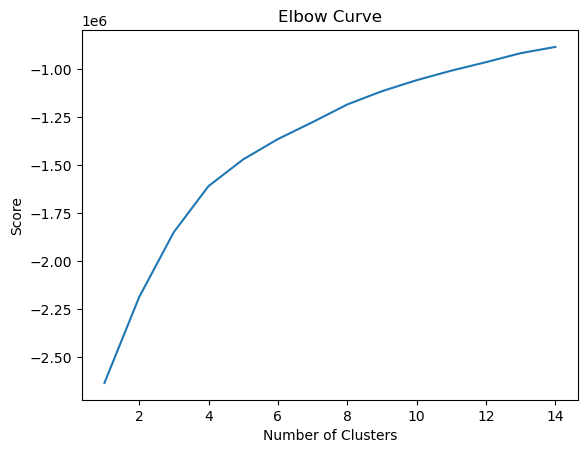

In [20]:
# plot the elbow curve using PyLab
pl.plot(num_cluster,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()


Observation: The optimal count for the cluster is four

# 05. k-Means Clustering

In [21]:
# create the k-means object
kmeans = KMeans(n_clusters=4, random_state = 42)

In [22]:
# fit the k-means object to the data
kmeans.fit(df_cluster)

/Users/lavinia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [23]:
# create a cluster column to view the values 
df_cluster['clusters'] = kmeans.fit_predict(df_cluster)

/Users/lavinia/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
# look inside the dataframe
df_cluster.head()

,Days_left_standardized,Duration (in min)_standardized,Total Stops_standardized,Price_standardized,Distance_km_standardized,Minutes_since_Midnight_DT_standardized,clusters
0,-1.7358,-1.377502,-2.250999,-0.880378,0.048207,1.178761,1
1,-1.7358,-1.343326,-2.250999,-0.850556,0.048207,1.722367,1
2,-1.7358,-1.366110,-2.250999,-0.855738,0.048207,1.631766,1
3,-1.7358,-1.377502,-2.250999,-0.856108,0.048207,0.967358,1
4,-1.7358,-1.366110,-2.250999,-0.847595,0.048207,1.178761,1


In [25]:
# check the observations count for each cluster
df_cluster['clusters'].value_counts()

3    168344
2    116528
0    102572
1     51755
Name: clusters, dtype: int64

In [26]:
# create a new data frame with the original features and add the assigned clusters
df_kmeans = pd.concat([df, df_cluster], axis = 1)

In [27]:
df_kmeans.head()

,Date of Booking,Booking Day,Date of Journey,Journey Day,Days_left,Airline,Flight Code,Flight Class,Departure_Time,Departure Location,...,Distance_km,Price_km_adjusted,Distance_cat,Days_left_standardized,Duration (in min)_standardized,Total Stops_standardized,Price_standardized,Distance_km_standardized,Minutes_since_Midnight_DT_standardized,clusters
0,2023-01-15,Sunday,2023-01-16,Monday,1,SpiceJet,SG-8169,Economy,20:00,Delhi,...,1148,4.647213,801 - 1200km,-1.7358,-1.377502,-2.250999,-0.880378,0.048207,1.178761,1
1,2023-01-15,Sunday,2023-01-16,Monday,1,Indigo,6E-2519,Economy,23:00,Delhi,...,1148,5.138502,801 - 1200km,-1.7358,-1.343326,-2.250999,-0.850556,0.048207,1.722367,1
2,2023-01-15,Sunday,2023-01-16,Monday,1,GO FIRST,G8- 354,Economy,22:30,Delhi,...,1148,5.053136,801 - 1200km,-1.7358,-1.366110,-2.250999,-0.855738,0.048207,1.631766,1
3,2023-01-15,Sunday,2023-01-16,Monday,1,SpiceJet,SG-8709,Economy,18:50,Delhi,...,1148,5.047038,801 - 1200km,-1.7358,-1.377502,-2.250999,-0.856108,0.048207,0.967358,1
4,2023-01-15,Sunday,2023-01-16,Monday,1,Air India,AI-805,Economy,20:00,Delhi,...,1148,5.187282,801 - 1200km,-1.7358,-1.366110,-2.250999,-0.847595,0.048207,1.178761,1


In [28]:
df_kmeans.columns

Index(['Date of Booking', 'Booking Day', 'Date of Journey', 'Journey Day',
       'Days_left', 'Airline', 'Flight Code', 'Flight Class', 'Departure_Time',
       'Departure Location', 'Departure_TimeCategory', 'Arrival_Time',
       'Arrival Location', 'Arrival_TimeCategory', 'Duration (in min)',
       'Total Stops', 'Price', 'Distance_km', 'Price_km_adjusted',
       'Distance_cat', 'Days_left_standardized',
       'Duration (in min)_standardized', 'Total Stops_standardized',
       'Price_standardized', 'Distance_km_standardized',
       'Minutes_since_Midnight_DT_standardized', 'clusters'],
      dtype='object')

In [37]:
cluster_data = df_kmeans[['Date of Booking', 'Booking Day', 'Date of Journey', 'Journey Day',
       'Days_left', 'Airline', 'Flight Code', 'Flight Class', 'Departure_Time',
       'Departure Location', 'Departure_TimeCategory', 'Arrival_Time',
       'Arrival Location', 'Arrival_TimeCategory', 'Duration (in min)',
       'Total Stops', 'Price', 'Distance_km', 'Price_km_adjusted',
       'Distance_cat','clusters']]

cluster_data.head()

,Date of Booking,Booking Day,Date of Journey,Journey Day,Days_left,Airline,Flight Code,Flight Class,Departure_Time,Departure Location,...,Arrival_Time,Arrival Location,Arrival_TimeCategory,Duration (in min),Total Stops,Price,Distance_km,Price_km_adjusted,Distance_cat,clusters
0,2023-01-15,Sunday,2023-01-16,Monday,1,SpiceJet,SG-8169,Economy,20:00,Delhi,...,22:05,Mumbai,After 6 PM,125,0,5335,1148,4.647213,801 - 1200km,1
1,2023-01-15,Sunday,2023-01-16,Monday,1,Indigo,6E-2519,Economy,23:00,Delhi,...,01:20,Mumbai,Before 6 AM,140,0,5899,1148,5.138502,801 - 1200km,1
2,2023-01-15,Sunday,2023-01-16,Monday,1,GO FIRST,G8- 354,Economy,22:30,Delhi,...,00:40,Mumbai,Before 6 AM,130,0,5801,1148,5.053136,801 - 1200km,1
3,2023-01-15,Sunday,2023-01-16,Monday,1,SpiceJet,SG-8709,Economy,18:50,Delhi,...,20:55,Mumbai,After 6 PM,125,0,5794,1148,5.047038,801 - 1200km,1
4,2023-01-15,Sunday,2023-01-16,Monday,1,Air India,AI-805,Economy,20:00,Delhi,...,22:10,Mumbai,After 6 PM,130,0,5955,1148,5.187282,801 - 1200km,1


In [38]:
# export data
cluster_data.to_csv(os.path.join(path, '02 Data', 'Prepared Data', 'cluster_data.csv'), index = False)

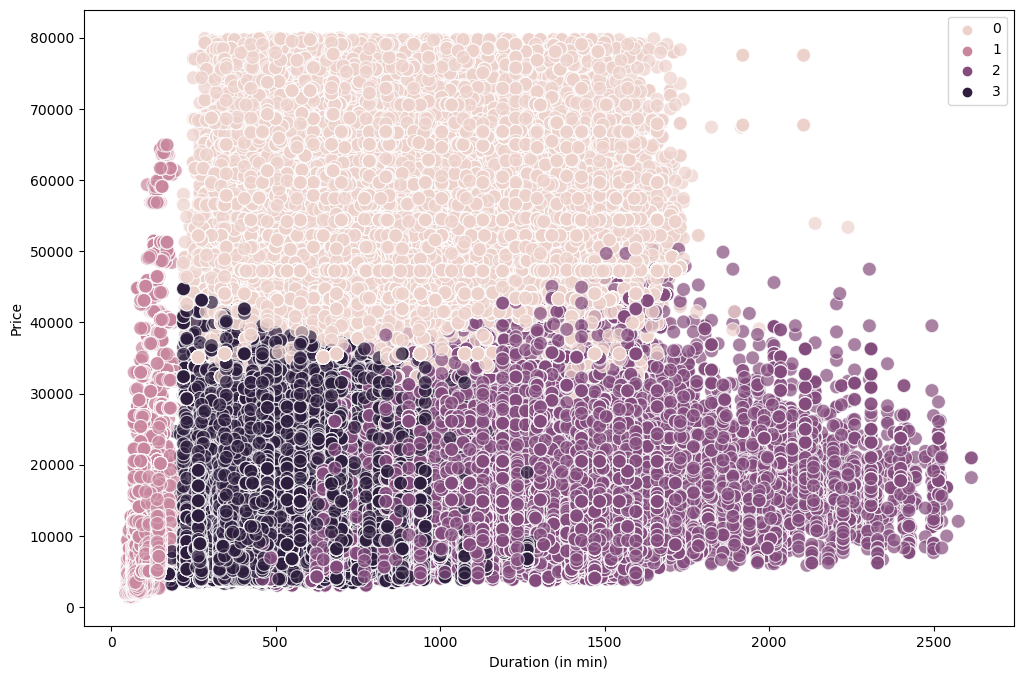

In [29]:
# plot the cluster for Price and Duration (in(min))

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_kmeans['Duration (in min)'], y=df_kmeans['Price'], hue=kmeans.labels_, s=100, alpha = 0.7) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Duration (in min)') # Label x-axis.
plt.ylabel('Price') # Label y-axis.
plt.show()

In [30]:
# create a crosstab between clusters and flight class
cross_tab_1 = pd.crosstab(df_kmeans['clusters'], df_kmeans['Flight Class'], normalize='index', dropna = False)
cross_tab_1

Flight Class,Business,Economy,First,Premiumeconomy
clusters,,,,
0,0.989295,0.000965,0.000000,0.009740
1,0.193662,0.703584,0.002261,0.100493
2,0.047516,0.659198,0.000000,0.293286
3,0.019965,0.801900,0.000000,0.178135


In [31]:
# create a crosstab between clusters and Departure_TimeCategory
cross_tab_2 = pd.crosstab(df_kmeans['clusters'], df_kmeans['Departure_TimeCategory'], normalize='index', dropna = False)
cross_tab_2

Departure_TimeCategory,12 PM - 6 PM,6 AM - 12 PM,After 6 PM,Before 6 AM
clusters,,,,
0,0.242825,0.433374,0.295929,0.027873
1,0.261347,0.339909,0.329688,0.069056
2,0.239479,0.163798,0.587490,0.009234
3,0.279725,0.577734,0.051983,0.090559


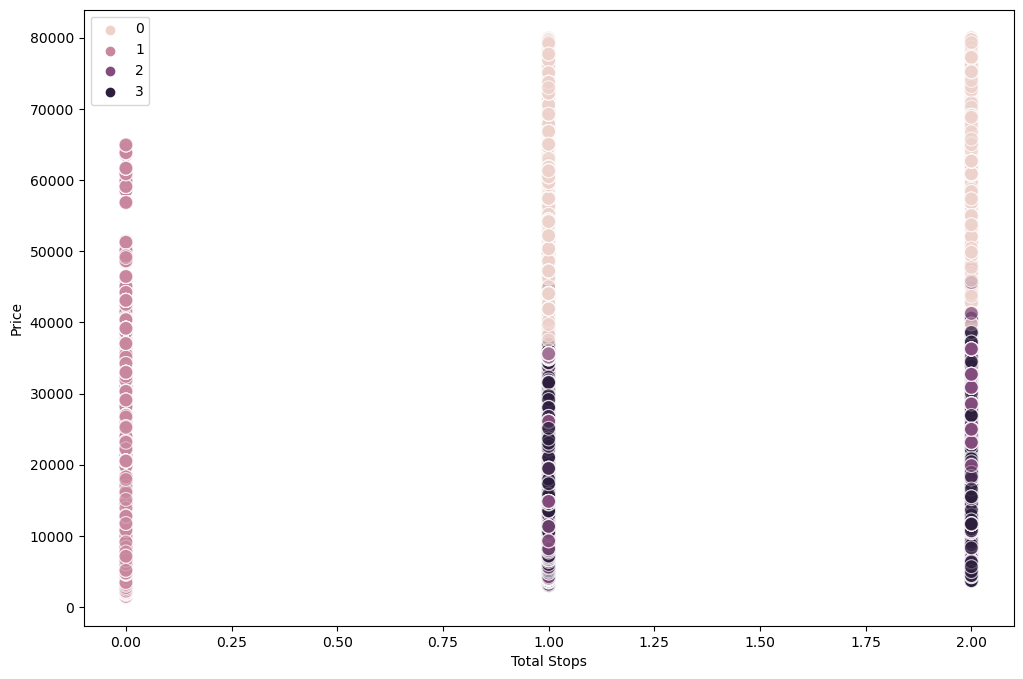

In [32]:
# plot the cluster for Price and Total Stops

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_kmeans['Total Stops'], y=df_kmeans['Price'], hue=kmeans.labels_, s=100, alpha = 0.7) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Total Stops') # Label x-axis.
plt.ylabel('Price') # Label y-axis.
plt.show()

/Users/lavinia/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


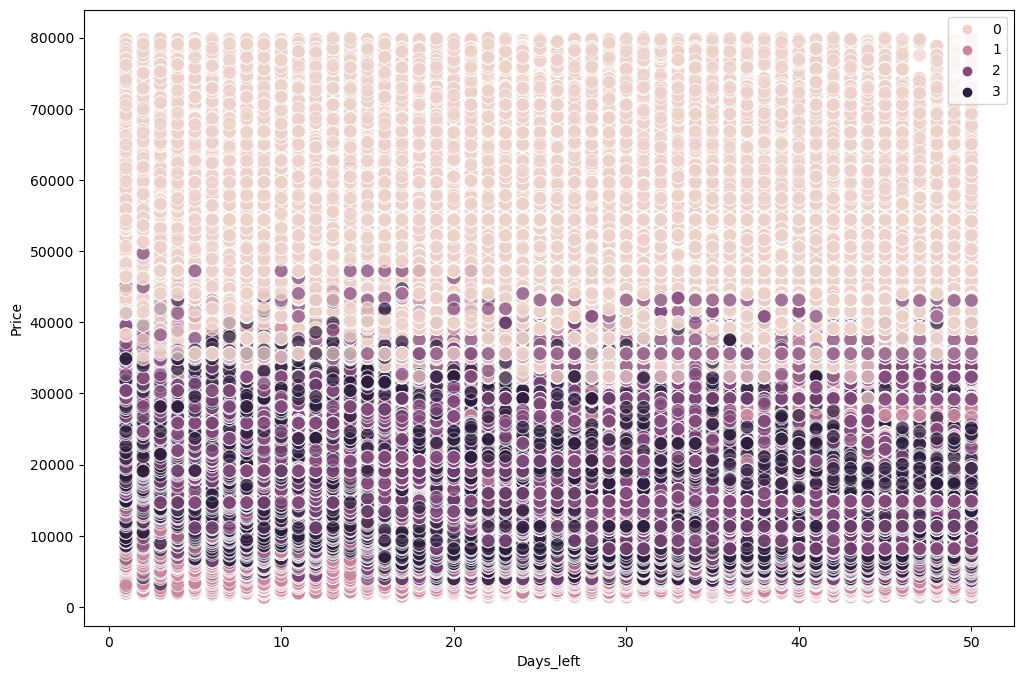

In [33]:
# plot the cluster for Price and Days Left

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_kmeans['Days_left'], y=df_kmeans['Price'], hue=kmeans.labels_, s=100, alpha = 0.7) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Days_left') # Label x-axis.
plt.ylabel('Price') # Label y-axis.
plt.show()

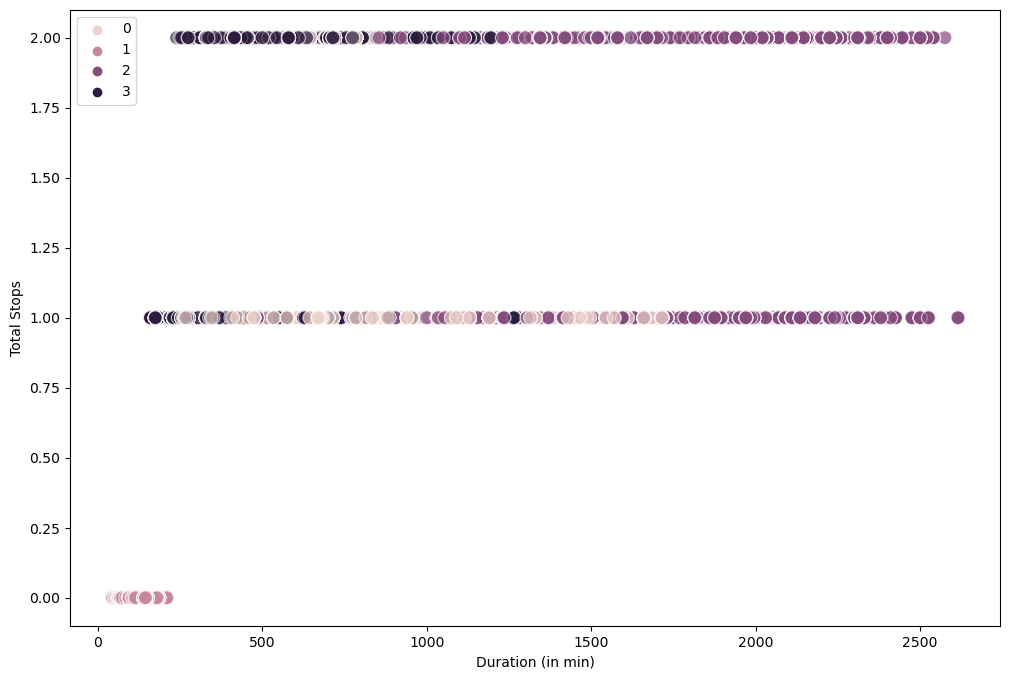

In [34]:
# plot the cluster for Total Stops and Duration (in(min))

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_kmeans['Duration (in min)'], y=df_kmeans['Total Stops'], hue=kmeans.labels_, s=100, alpha = 0.7) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Duration (in min)') # Label x-axis.
plt.ylabel('Total Stops') # Label y-axis.
plt.show()

In [35]:
# run the descriptive analytics by cluster
df_kmeans.groupby('clusters').agg({'Price':['mean', 'median', 'min', 'max'],
                                   'Duration (in min)':['mean', 'median'], 
                                   'Distance_km':['mean', 'median'], 
                                   'Total Stops':['mean', 'median', 'min', 'max'],
                                   'Price_km_adjusted':['mean', 'median'],
                                   'Days_left':['mean', 'median']})

Price                        Duration (in min)          \
                  mean   median    min    max              mean  median   
clusters                                                                  
0         53064.461568  52012.0  29292  79999        846.861083   805.0   
1         10353.052304   6605.0   1307  64928        126.768505   130.0   
2         13933.734896  12335.0   3061  50894       1166.451025  1165.0   
3         12198.022412  11005.5   3193  44709        541.069803   485.0   

          Distance_km         Total Stops                Price_km_adjusted  \
                 mean  median        mean median min max              mean   
clusters                                                                     
0         1109.229780  1148.0    1.011787    1.0   1   2         60.602501   
1         1126.557917  1148.0    0.000000    0.0   0   0          9.593721   
2         1125.514872  1180.0    1.119276    1.0   1   2         15.634549   
3         1138.185406  1180.0    1.069221    1.0   1   2         13.190960   

                     Days_left         
             median       mean median  
clusters                               
0         47.219473  26.656300   27.0  
1          5.841979  25.601913   26.0  
2         11.240000  24.817100   24.0  
3          9.926150  25.943907   26.0

Observation:

- Cluster 1 stands out with the lowest median price of INR6,605, which suggests that 50% of flights in this cluster are relatively affordable. Cluster 1 also have the shortest median flight duration of 130min and zero number of stops, indicating direct flights. It's noted that although the median price is low, the presence of higher average price of INR10,353, suggests that there are flights within this cluster that have significantly higher fare prices. This variation from median may indicate that the existence of both budget-friendly options and premium options within this cluster. This cluster seems to represent of both budget-conscious travellers, who prioritize efficiency and lower fares, and travellers who are willing to pay more for premium services, such as higher flight classes and better airline amenities.

- Cluster 0 stands out with the highest median fare price of INR52,012, coupled with a median flight duration of 805min. This suggests that the flights within cluster 0 are characterized by a combination of higher fare prices and extended travel duration. Notably, all flights within this cluster include stopovers, which contributes to the longer overall longer flight time. Additionaly, the majority of passengers in this cluster (99%) opted for Business Class. This implies that travellers in this cluster are inclined towards comprehensive travel experiences and premium services offered by the Business Class. 

- Cluster 2 demonstrates a median price of INR12,335 and the highest median flight duration of 1165min. All flights within this cluster involve stopovers. The majority of passengers in this cluster opted for Economy (66%) and Premium Economy (29%). 59% of departures from this cluster occur after 6PM. This suggests that the travellers in this clusters are willing to embark on longer journeys in exchange for potential cost savings and comfortable with evening departures.

- Cluster 3 exhibits a lower median price of INR11,066 and a median flight duration of 485min compared to Cluster 2. Similar to Cluster 2, all flights within this cluster involve stopovers. The majority of passengers in this cluster also opted for Economy (80%) and Premium Economy (18%). Notable, the key distinction from Cluster 2 is the significanty shorter flight duration in this cluster. Additionally, a majority of departures from Cluster 3 fall under '6AM-12PM' (58%) and '12PM-6PM' (28%). In summary, Cluster 3 represents passengers who are cost-conscious, seek shorter travel duration, are comfortable with flights involving stopovers, and prefer daytime flights.